In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tqdm import tqdm
import os
import glob
import numpy as np
import shap

In [2]:
mgus_list_aiims = pd.read_csv('/home/vivek/aiims_data_processing/top250_feature_matrix/mgus_common_genes.csv')['Sample'].values.tolist()
mm_list_aiims = pd.read_csv('/home/vivek/aiims_data_processing/top250_feature_matrix/mm_common_genes.csv')['Sample'].values.tolist()
mgus_list_ega = pd.read_csv('/home/vivek/ega_data_1901/top250_feature_matrix/mgus_common_genes.csv')['Sample'].values.tolist()
mm_list_mmrf = pd.read_csv('/home/vivek/mmrf_data/mmrf_variant_callers/hg19/top250_feature_matrix/mm_common_genes.csv')['Sample'].values.tolist()

total_mm_list = mm_list_aiims + mm_list_mmrf
total_mgus_list = mgus_list_ega + mgus_list_aiims
total_list = total_mm_list + total_mgus_list

genelist = pd.read_csv('/home/vivek/jupyter_notebooks/bio_dgi_extension/feature_matrix/genes798feature26/CR-MGUS-10_10.csv', index_col=0).index.tolist()

# Modules for getting best shap and corrosponding norm data

In [3]:
with open('shap_values_fold1.pickle','rb') as handle:
    shap_values_fold1 = pickle.load(handle)

with open('shap_values_fold2.pickle','rb') as handle:
    shap_values_fold2 = pickle.load(handle)
    
with open('shap_values_fold3.pickle','rb') as handle:
    shap_values_fold3 = pickle.load(handle)
    
with open('shap_values_fold4.pickle','rb') as handle:
    shap_values_fold4 = pickle.load(handle)
    
with open('shap_values_fold5.pickle','rb') as handle:
    shap_values_fold5 = pickle.load(handle)

In [4]:
def get_shap_samplewise(sample, shap_values_foldno):
    if sample in shap_values_foldno.keys():
        if sample in total_mm_list: #for MM sample
            shap_values = shap_values_foldno[sample]['shap_values'][0]
            exp_value = shap_values_foldno[sample]['base_values'][0]
        else: # For MGUS Sample
            shap_values = shap_values_foldno[sample]['shap_values'][1]
            exp_value = shap_values_foldno[sample]['base_values'][1]

        data_points = shap_values_foldno[sample]['data']
    else:
        print(f'The sample was not correctly mapped in {shap_values_foldno}')
        shap_values, exp_values, data_points = [], [], []
    
    return shap_values, exp_value, data_points

In [5]:
def get_shap_samplewise2(sample):
    correct_cls_dict = {}
    if sample in shap_values_fold1['fold_1'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold1['fold_1'])
        correct_cls_dict['fold1'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold2['fold_2'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold2['fold_2'])
        correct_cls_dict['fold2'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold3['fold_3'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold3['fold_3'])
        correct_cls_dict['fold3'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold4['fold_4'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold4['fold_4'])
        correct_cls_dict['fold4'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    if sample in shap_values_fold5['fold_5'].keys():
        shap_values, exp_value, data_points = get_shap_samplewise(sample,shap_values_fold5['fold_5'])
        correct_cls_dict['fold_5'] = {'shap_values':shap_values, 'base_value':exp_value, 'data':data_points}
        
    return correct_cls_dict

In [6]:
def dominent_shap_for_each_fold(shap_dict, foldno):
    ashap = shap_dict[foldno]['shap_values'].reshape(26,798)
    negative_shap = [(sum(j[j<0])) for j in ashap]
    positive_shap = [(sum(j[j>0])) for j in ashap]
    dominent_shap = [i if np.abs(i)>j else j for (i,j) in zip(negative_shap,positive_shap)]
    return dominent_shap

In [7]:
def features_for_dominent_shap(shap_dict, foldno):
    adata = shap_dict[foldno]['data'].reshape(26,798)
    ashap = shap_dict[foldno]['shap_values'].reshape(26,798)
    dominent_shap = dominent_shap_for_each_fold(shap_dict, foldno)
    shap_for_each_feature = []
    shap_data = []
    for dom in dominent_shap:
        shap_index = dominent_shap.index(dom)
        shap_for_each_feature.append(list(ashap[shap_index]))
        shap_data.append(list(adata[shap_index]))
    # print(f'dominent_shape: {dominent_shap.__len__()}, shap_for_each_feature: {shap_for_each_feature.__len__()}, shap_data: {shap_data.__len__()}')
    return dominent_shap, shap_for_each_feature, shap_data

In [8]:
def get_shap_features(sample):
    sample_shap = get_shap_samplewise2(sample)
    dominent_shap_dict = {}
    best_shap_values = []
    shap_each_feat = []
    expected_values = []
    data_points = []
    for k,v in sample_shap.items():
        shap_out1, shap_out2, shap_out3 = features_for_dominent_shap(sample_shap, k)
        dominent_shap_dict[k] = {}
        dominent_shap_dict[k]['dominent_shap'] = shap_out1
        dominent_shap_dict[k]['shap_for_each_feature'] = shap_out2
        dominent_shap_dict[k]['data'] = shap_out3
        dominent_shap_dict[k]['base_value'] = sample_shap[k]['base_value']

    for j in range(26):
        shap_across_folds = [dominent_shap_dict[k]['dominent_shap'][j] for k in dominent_shap_dict.keys()]
        shap_each_feature_across_folds = [dominent_shap_dict[k]['shap_for_each_feature'][j] for k in dominent_shap_dict.keys()]
        data_points_across_folds = [dominent_shap_dict[k]['data'][j] for k in dominent_shap_dict.keys()]
        base_value_across_folds = [dominent_shap_dict[k]['base_value'] for k in dominent_shap_dict.keys()]
        try:
            idx = shap_across_folds.index(max(np.abs(shap_across_folds)))
            best_shap_values.append(shap_across_folds[idx])
            shap_each_feat.append(shap_each_feature_across_folds[idx])
            expected_values.append(base_value_across_folds[idx])
            data_points.append(data_points_across_folds[idx])
        except: 
            idx = shap_across_folds.index(-max(np.abs(shap_across_folds)))
            best_shap_values.append(shap_across_folds[idx])
            shap_each_feat.append(shap_each_feature_across_folds[idx])
            expected_values.append(base_value_across_folds[idx])
            data_points.append(data_points_across_folds[idx])

    return shap_each_feat, data_points, np.mean(expected_values)

In [9]:
def get_feature_mat(sample):
    path = '/home/vivek/jupyter_notebooks/bio_dgi_extension/feature_matrix/genes798feature26'
    df = pd.read_csv(os.path.join(path,sample),index_col=0, header=0)
    return df

In [10]:
correctly_mapped_samples = list(set(list(shap_values_fold1['fold_1'].keys()) + list(shap_values_fold2['fold_2'].keys()) + list(shap_values_fold3['fold_3'].keys()) + list(shap_values_fold4['fold_4'].keys()) + list(shap_values_fold5['fold_5'].keys())))

In [11]:
path = '/home/vivek/jupyter_notebooks/bio_dgi_extension/feature_matrix/genes798feature26'
feat_mat = pd.read_csv(os.path.join(path,correctly_mapped_samples[0]),index_col=0, header=0)
feat_mat = feat_mat[feat_mat.index.isin(genelist)]
feat_names = feat_mat.columns
index_names = feat_mat.index

In [12]:
shap_df_combined = pd.DataFrame(columns = feat_names)
shap_data_df_combined = pd.DataFrame(columns = feat_names)
shap_expected_value_combined = []
for sam in tqdm(correctly_mapped_samples):
    shap_values, data_points, expected_values = get_shap_features(sam)
    shap_values = pd.DataFrame(np.array(shap_values).reshape(798,26),index=genelist,columns=feat_names)
    shap_values = shap_values[shap_values.index.isin(genelist)]
    data_points = pd.DataFrame(np.array(data_points).reshape(798,26),index=genelist,columns=feat_names)
    data_points = data_points[data_points.index.isin(genelist)]
    shap_expected_value_combined.append(expected_values)

100%|██████████| 1199/1199 [00:31<00:00, 38.62it/s]


In [14]:
?shap.plots.beeswarm

Signature:
shap.plots.beeswarm(
    shap_values,
    max_display=10,
    order=shap.Explanation.abs.mean(0),
    clustering=None,
    cluster_threshold=0.5,
    color=None,
    axis_color='#333333',
    alpha=1,
    show=True,
    log_scale=False,
    color_bar=True,
    plot_size='auto',
    color_bar_label='Feature value',
)
Docstring:
Create a SHAP beeswarm plot, colored by feature values when they are provided.

Parameters
----------
shap_values : Explanation
    This is an Explanation object containing a matrix of SHAP values (# samples x # features).

max_display : int
    How many top features to include in the plot (default is 20, or 7 for interaction plots)

plot_size : "auto" (default), float, (float, float), or None
    What size to make the plot. By default the size is auto-scaled based on the number of
    features that are being displayed. Passing a single float will cause each row to be that 
    many inches high. Passing a pair of floats will scale the plot by that
    

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


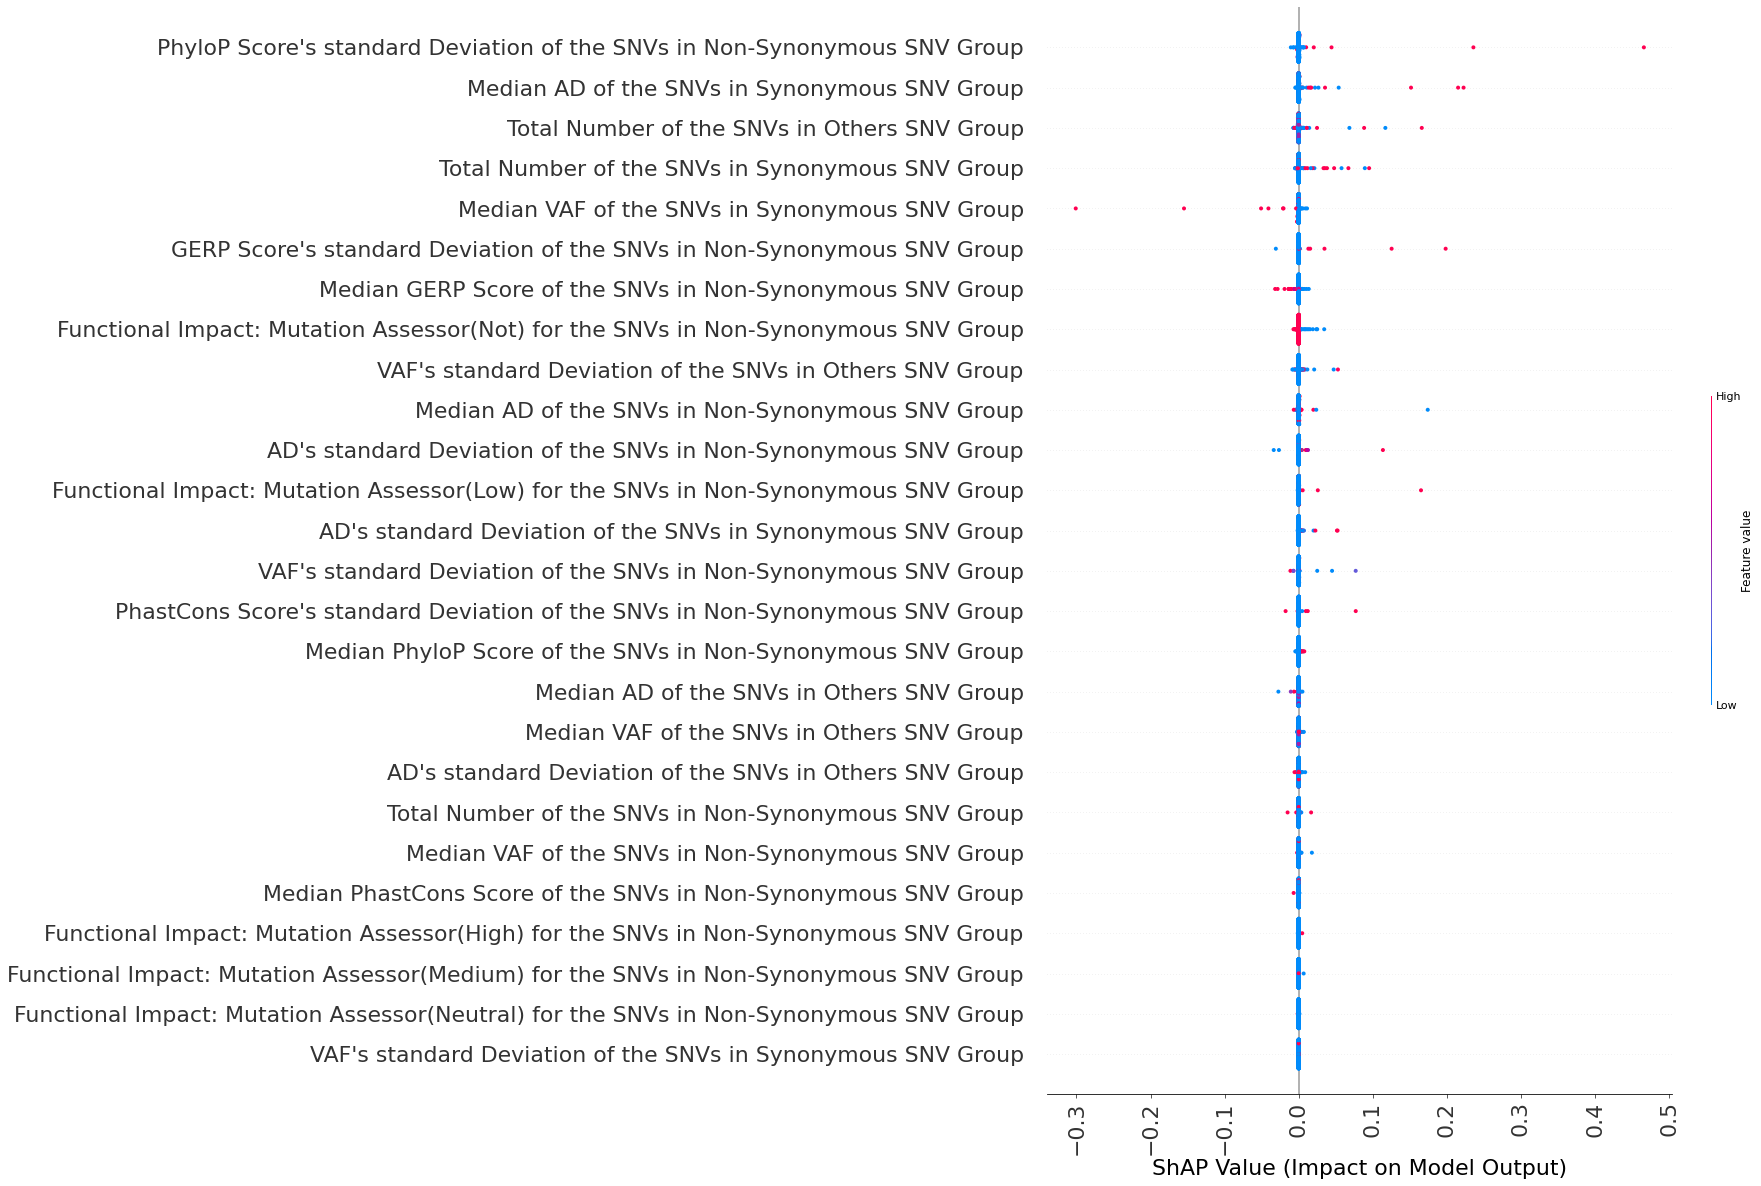

In [39]:
feature_list = ['Total Number of the SNVs in Synonymous SNV Group',
                'Median VAF of the SNVs in Synonymous SNV Group',
                'VAF\'s standard Deviation of the SNVs in Synonymous SNV Group',
                'Median AD of the SNVs in Synonymous SNV Group',
                'AD\'s standard Deviation of the SNVs in Synonymous SNV Group', 

                'Total Number of the SNVs in Non-Synonymous SNV Group',
                'Median VAF of the SNVs in Non-Synonymous SNV Group',
                'VAF\'s standard Deviation of the SNVs in Non-Synonymous SNV Group', 
                'Median AD of the SNVs in Non-Synonymous SNV Group',
                'AD\'s standard Deviation of the SNVs in Non-Synonymous SNV Group',

                'Median GERP Score of the SNVs in Non-Synonymous SNV Group',
                'GERP Score\'s standard Deviation of the SNVs in Non-Synonymous SNV Group', 
                
                'Median PhyloP Score of the SNVs in Non-Synonymous SNV Group',
                'PhyloP Score\'s standard Deviation of the SNVs in Non-Synonymous SNV Group',

                'Median PhastCons Score of the SNVs in Non-Synonymous SNV Group',
                'PhastCons Score\'s standard Deviation of the SNVs in Non-Synonymous SNV Group',

                'Functional Impact: Mutation Assessor(Not) for the SNVs in Non-Synonymous SNV Group',
                'Functional Impact: Mutation Assessor(High) for the SNVs in Non-Synonymous SNV Group',
                'Functional Impact: Mutation Assessor(Medium) for the SNVs in Non-Synonymous SNV Group',
                'Functional Impact: Mutation Assessor(Low) for the SNVs in Non-Synonymous SNV Group',
                'Functional Impact: Mutation Assessor(Neutral) for the SNVs in Non-Synonymous SNV Group',

                'Total Number of the SNVs in Others SNV Group',
                'Median VAF of the SNVs in Others SNV Group',
                'VAF\'s standard Deviation of the SNVs in Others SNV Group', 
                'Median AD of the SNVs in Others SNV Group',
                'AD\'s standard Deviation of the SNVs in Others SNV Group', 


                ]

# shap.plots.beeswarm(shap.Explanation(np.array(shap_values),
#                                      np.array(shap_expected_value_combined),
#                                      np.array(data_points),
#                                      ),
#                     max_display = 30,
#                     show=False,
#                     plot_size = (14,20),
#                     color = plt.get_cmap("tab20b"),
#                     )#
shap.plots.beeswarm(shap.Explanation(np.array(shap_values),
                                     np.array(shap_expected_value_combined),
                                     np.array(data_points),
                                     feature_names = feature_list),
                    max_display = 30,
                    show=False,
                    plot_size = (14,20),
                    
                    )#

plt.yticks(fontsize=22)
plt.xticks(fontsize=22, rotation=90)
plt.xlabel("ShAP Value (Impact on Model Output)",fontsize=22)
plt.tight_layout()
plt.savefig('feature_ranking.png',dpi=400)
plt.savefig('feature_ranking.jpg',dpi=400)
plt.savefig('feature_ranking.svg',dpi=400)